# Model Making

### Description

This notebook file must be run after taking the output from datasetPreparation.ipynb

Training of the model will be done ONLY. Manipulation of the dataset must NOT be done here. Only importing of dataset is allowed. 

Train Test Splits will be done on datasetPrepation.ipynb

This notebook will output the top performing ZERO-SHOT models. No hyperparameter tuning will be done in this notebook.

Technique used will be the following:

In [183]:
import pandas as pd
import numpy as np
import time

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import lightgbm as lgb
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, accuracy_score

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

import joblib
import os
import seaborn as sns
import matplotlib.pyplot as plt

### Importing of dataset: train, validation, and test sets

In [184]:
X_train = pd.read_csv('data/cleaned/X_train.csv')
X_test = pd.read_csv('data/cleaned/X_test.csv')
y_train = pd.read_csv('data/cleaned/y_train.csv')
y_test = pd.read_csv('data/cleaned/y_test.csv')

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (39818, 6)
X_test shape: (17065, 6)
y_train shape: (39818, 1)
y_test shape: (17065, 1)


I get an error sometimes that y_train and y_test is not in the correct shape.

In [185]:
# Reshape y_train and y_test to be 1D arrays
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

### Functions

This function will just print the report when you do output_dict=True when calling the classification_report function.

In [188]:
def print_classification_report(report):
    # Define the headers
    headers = ["precision", "recall", "f1-score", "support"]
    
    # Print the header
    print(f"{'':>15} {'precision':>10} {'recall':>10} {'f1-score':>10} {'support':>10}")
    
    # Print the per-class metrics
    for class_name, metrics in report.items():
        if class_name in ['accuracy', 'macro avg', 'weighted avg']:
            continue  # Skip overall metrics for now
        print(f"{class_name:>15} {metrics['precision']:>10.2f} {metrics['recall']:>10.2f} {metrics['f1-score']:>10.2f} {metrics['support']:>10}")
    
    # Print the overall accuracy
    print(f"\n{'accuracy':>15} {' ':>10} {' ':>10} {report['accuracy']:>10.2f} {sum([report[class_name]['support'] for class_name in report if class_name not in ['accuracy', 'macro avg', 'weighted avg']]):>10}")

    # Print the macro and weighted averages
    for avg in ['macro avg', 'weighted avg']:
        metrics = report[avg]
        print(f"{avg:>15} {metrics['precision']:>10.2f} {metrics['recall']:>10.2f} {metrics['f1-score']:>10.2f} {metrics['support']:>10}")


### Training of model

The following models will be used for training on a stars classification dataset:

1. **Logistic Regression**: A linear model for binary classification, extended here for multi-class classification. It models the probability of each class using the logistic function.

2. **Support Vector Machines (SVM)**: A classification model that finds the hyperplane best separating the data into classes, effective for high-dimensional data.

3. **Gaussian Naive Bayes**: A probabilistic classifier based on Bayes' theorem with the assumption of feature independence. Suitable for high-dimensional datasets.

4. **K-Nearest Neighbors (KNN)**: An instance-based learning algorithm that classifies a sample based on the majority class among its k-nearest neighbors, effective for non-linear decision boundaries.

5. **Decision Trees**: A model that splits the data into subsets based on feature values, providing a clear visual representation of decision-making, suitable for both classification and regression.

6. **Extreme Gradient Boost (XGBoost)**: An efficient implementation of gradient-boosted decision trees designed for speed and performance, widely used for structured/tabular data.

7. **Light Gradient Boost Machine (LightGBM)**: A highly efficient gradient boosting framework optimized for speed and memory usage, making it suitable for large datasets and high-dimensional data.

8. **Random Forest:** An ensemble method that uses multiple decision trees to improve classification accuracy and control overfitting. It builds numerous decision trees during training and outputs the mode of the classes for classification tasks.

9. **AdaBoost:** An ensemble method that combines multiple weak classifiers to form a strong classifier. It adjusts the weights of incorrectly classified instances so that subsequent classifiers focus more on difficult cases, improving overall accuracy.

10. **Feedforward Neural Network (FNN)**: A simple type of artificial neural network where information moves in one direction, from input to output, suitable for basic and complex classification tasks.


**train_zero_shot** gets the model and trains it one time only.

Returns: classification report, training classification report, predictions, probabilities, and the actual model

In [189]:
def train_zero_shot(model, X_train, X_test, y_train, y_test):
    # Fit model once
    model.fit(X_train, y_train)

    # Predict X_test
    y_pred = model.predict(X_test)

    # Get probabilities
    probabilities = model.predict_proba(X_test)

    # Get classification report
    class_report = classification_report(y_test, y_pred, output_dict=True)

    # Get training accuracy
    train_pred = model.predict(X_train)
    training_class_report = classification_report(y_train, train_pred, output_dict=True)

    return class_report, training_class_report, y_pred, probabilities, model
    

**train_with_tuning** trains the model with hyperparameter tuning

returns: classification report and the best model from tuning

In [190]:
def train_with_tuning(model, param_grid, X_train, X_test, y_train, y_test):
    # Perform hyperparameter tuning with GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5, verbose=3, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Get the best model
    best_model = grid_search.best_estimator_
    
    # Train the best model on the training set
    best_model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = best_model.predict(X_test)
    
    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model Accuracy: {accuracy:.2f}")
    
    # Print the classification report
    class_report = classification_report(y_test, y_pred, output_dict=True)
    print("Classification Report:")
    print(class_report)
    
    return class_report, best_model 

##### Actual training - without Neural Network

In [191]:
model_titles = [
    'Logistic Regression',
    'Support Vector Machines',
    'Gaussian Naive Bayes',
    'K-Nearest Neighbors',
    'Decision Trees',
    'Extreme Gradient Boost',
    'Light Gradient Boost Machine',
    'Random Forest',
    'AdaBoost',
    'Feedforward Neural Network'
]

# Intialize all models
models_zero_shot = [LogisticRegression(), 
                    SVC(probability=True), 
                    GaussianNB(), 
                    KNeighborsClassifier(), 
                    DecisionTreeClassifier(), 
                    XGBClassifier(),
                    lgb.LGBMClassifier(random_state=42),
                    RandomForestClassifier(),
                    AdaBoostClassifier()
                    ]

# Put performances of zero shot here
zero_shot_performances = []

# Put TRAINING performances of zero shot here
zero_shot_training_performances = []

# Predictions for each model
y_predictions_per_model = []

# Probabilities for each model
probabilities_per_model = []

# Models after zero shot fitting
models_after_fitting_zero_shot = []

In [192]:
for model in models_zero_shot:
    report, training_report, predictions, probabilities, model_output = train_zero_shot(model, X_train, X_test, y_train, y_test)

    zero_shot_performances.append(report)

    zero_shot_training_performances.append(training_report)

    y_predictions_per_model.append(predictions)

    probabilities_per_model.append(probabilities)

    models_after_fitting_zero_shot.append(model_output)

    print(f"Model: {model_output}")
    print_classification_report(report)
    print('\n---------------------------\n')


Model: LogisticRegression()
                 precision     recall   f1-score    support
              0       0.93       0.95       0.94       5688
              1       0.95       0.93       0.94       5688
              2       0.99       1.00       1.00       5689

       accuracy                             0.96      17065
      macro avg       0.96       0.96       0.96      17065
   weighted avg       0.96       0.96       0.96      17065

---------------------------

Model: SVC(probability=True)
                 precision     recall   f1-score    support
              0       0.94       0.97       0.95       5688
              1       0.98       0.93       0.95       5688
              2       0.99       1.00       1.00       5689

       accuracy                             0.97      17065
      macro avg       0.97       0.97       0.97      17065
   weighted avg       0.97       0.97       0.97      17065

---------------------------

Model: GaussianNB()
                 prec

##### Neural Network

In [200]:
def train_neural_network(X_train, X_test, y_train, y_test):
    # Determine the number of classes
    num_classes = 3
    
    # Convert labels to one-hot encoding
    y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes)
    
    # Define the neural network model
    model = tf.keras.models.Sequential()
    model.add(layers.InputLayer(input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train_one_hot, epochs=100, batch_size=32, validation_split=0.1)

    # Make predictions on the test set
    y_pred_probs = model.predict(X_test) # Returning this value to also get probabilities
    y_pred = y_pred_probs.argmax(axis=1)

    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model Accuracy: {accuracy:.2f}")

    # Get the classification report
    report = classification_report(y_test, y_pred, output_dict=True)

    # Make predictions on the training set
    train_pred_probs = model.predict(X_train) # Returning this value to also get probabilities
    train_pred = train_pred_probs.argmax(axis=1)

    training_report = classification_report(y_train, train_pred, output_dict=True)


    return report, training_report, y_pred, y_pred_probs, model

In [201]:
report, training_report, prediction, probabilities, model_output = train_neural_network(X_train, X_test, y_train, y_test)

print_classification_report(report)
zero_shot_performances.append(report)

zero_shot_training_performances.append(training_report)

y_predictions_per_model.append(prediction)

probabilities_per_model.append(probabilities)

models_after_fitting_zero_shot.append(model_output)

Epoch 1/100
1120/1120 [==============================] - 1s 853us/step - loss: 0.1802 - accuracy: 0.9446 - val_loss: 0.1112 - val_accuracy: 0.9641
Epoch 2/100
1120/1120 [==============================] - 1s 739us/step - loss: 0.1143 - accuracy: 0.9624 - val_loss: 0.1051 - val_accuracy: 0.9656
Epoch 3/100
1120/1120 [==============================] - 1s 729us/step - loss: 0.1102 - accuracy: 0.9637 - val_loss: 0.1003 - val_accuracy: 0.9691
Epoch 4/100
1120/1120 [==============================] - 1s 719us/step - loss: 0.1079 - accuracy: 0.9644 - val_loss: 0.1024 - val_accuracy: 0.9684
Epoch 5/100
1120/1120 [==============================] - 1s 760us/step - loss: 0.1056 - accuracy: 0.9650 - val_loss: 0.0992 - val_accuracy: 0.9691
Epoch 6/100
1120/1120 [==============================] - 1s 730us/step - loss: 0.1026 - accuracy: 0.9664 - val_loss: 0.0970 - val_accuracy: 0.9709
Epoch 7/100
1120/1120 [==============================] - 1s 725us/step - loss: 0.1017 - accuracy: 0.9663 - val_loss: 0

### Compare all zero shot performances

In [196]:
model_titles = [
    'Logistic Regression',
    'Support Vector Machines',
    'Gaussian Naive Bayes',
    'K-Nearest Neighbors',
    'Decision Trees',
    'Extreme Gradient Boost',
    'Light Gradient Boost Machine',
    'Random Forest',
    'AdaBoost',
    'Feedforward Neural Network'
]

for title, report in zip(model_titles, zero_shot_performances):
    try:
        print(title)
        print_classification_report(report)
        print('\n-----------------------------------------------------------\n')
    except Exception as e:
        print(e)

Logistic Regression
                 precision     recall   f1-score    support
              0       0.93       0.95       0.94       5688
              1       0.95       0.93       0.94       5688
              2       0.99       1.00       1.00       5689

       accuracy                             0.96      17065
      macro avg       0.96       0.96       0.96      17065
   weighted avg       0.96       0.96       0.96      17065

-----------------------------------------------------------

Support Vector Machines
                 precision     recall   f1-score    support
              0       0.94       0.97       0.95       5688
              1       0.98       0.93       0.95       5688
              2       0.99       1.00       1.00       5689

       accuracy                             0.97      17065
      macro avg       0.97       0.97       0.97      17065
   weighted avg       0.97       0.97       0.97      17065

---------------------------------------------------

In [197]:
for title, report in zip(model_titles, zero_shot_training_performances):
    try:
        print(title)
        print_classification_report(report)
        print('\n-----------------------------------------------------------\n')
    except Exception as e:
        print(e)

Logistic Regression
                 precision     recall   f1-score    support
              0       0.93       0.95       0.94      13273
              1       0.96       0.93       0.94      13273
              2       0.99       1.00       0.99      13272

       accuracy                             0.96      39818
      macro avg       0.96       0.96       0.96      39818
   weighted avg       0.96       0.96       0.96      39818

-----------------------------------------------------------

Support Vector Machines
                 precision     recall   f1-score    support
              0       0.94       0.97       0.95      13273
              1       0.98       0.94       0.96      13273
              2       0.99       1.00       0.99      13272

       accuracy                             0.97      39818
      macro avg       0.97       0.97       0.97      39818
   weighted avg       0.97       0.97       0.97      39818

---------------------------------------------------

##### Checking for overfitting and underfitting models

Here we can compare testing and training accuracy. 

##### **Overfitting**

Just looking at the data we can assume a model is overfitting if there is high discrepancy between the training and testing accuracy and/or if the training accuracy is equal or close to 1.

**Decision Trees** is definitely overfitted due to its training accuracy being equal to 1

**Random Forest** and **Extreme Gradient Boost** may possibly be overfitting due to the high discrepancy in training and testing accuracy. Despite the possibility of overfitting, it is still the top scoring models among the ten

--

##### **Underfitting**

We can assume a model is underfitting if its training and testing accuracies are low.

**Gaussian Naive Bayes** and **AdaBoost** may suggest underfitting due to the very low testing and training accuracy relative to the other models.

In [199]:
model_accuracies = pd.DataFrame(columns=('Model', 'Testing Accuracy', 'Training Accuracy'))

for title, report, training_report in zip(model_titles, zero_shot_performances, zero_shot_training_performances):
    model_accuracies = pd.concat([model_accuracies, pd.DataFrame({'Model': [title], 'Testing Accuracy': [report['accuracy']], 'Training Accuracy': [training_report['accuracy']]})], ignore_index=True)

model_accuracies.sort_values('Testing Accuracy', ascending=False)

,Model,Testing Accuracy,Training Accuracy
7,Random Forest,0.974626,0.999950
5,Extreme Gradient Boost,0.973513,0.990055
6,Light Gradient Boost Machine,0.972986,0.983224
3,K-Nearest Neighbors,0.968649,0.974233
1,Support Vector Machines,0.967184,0.967326
9,Feedforward Neural Network,0.962731,0.962705
0,Logistic Regression,0.959156,0.959491
4,Decision Trees,0.958980,1.000000
2,Gaussian Naive Bayes,0.883211,0.881335
8,AdaBoost,0.622678,0.622934


### Error Analysis

Here we have a confusion matrix that shows which labels are predicted correctly and which are not. It can be seen that most models find GALAXY and QSO a bit more confusing but many of the STAR class can be easy to predict.

This is most especially present in **Adaboost** and **Gaussian Naive Bayes**

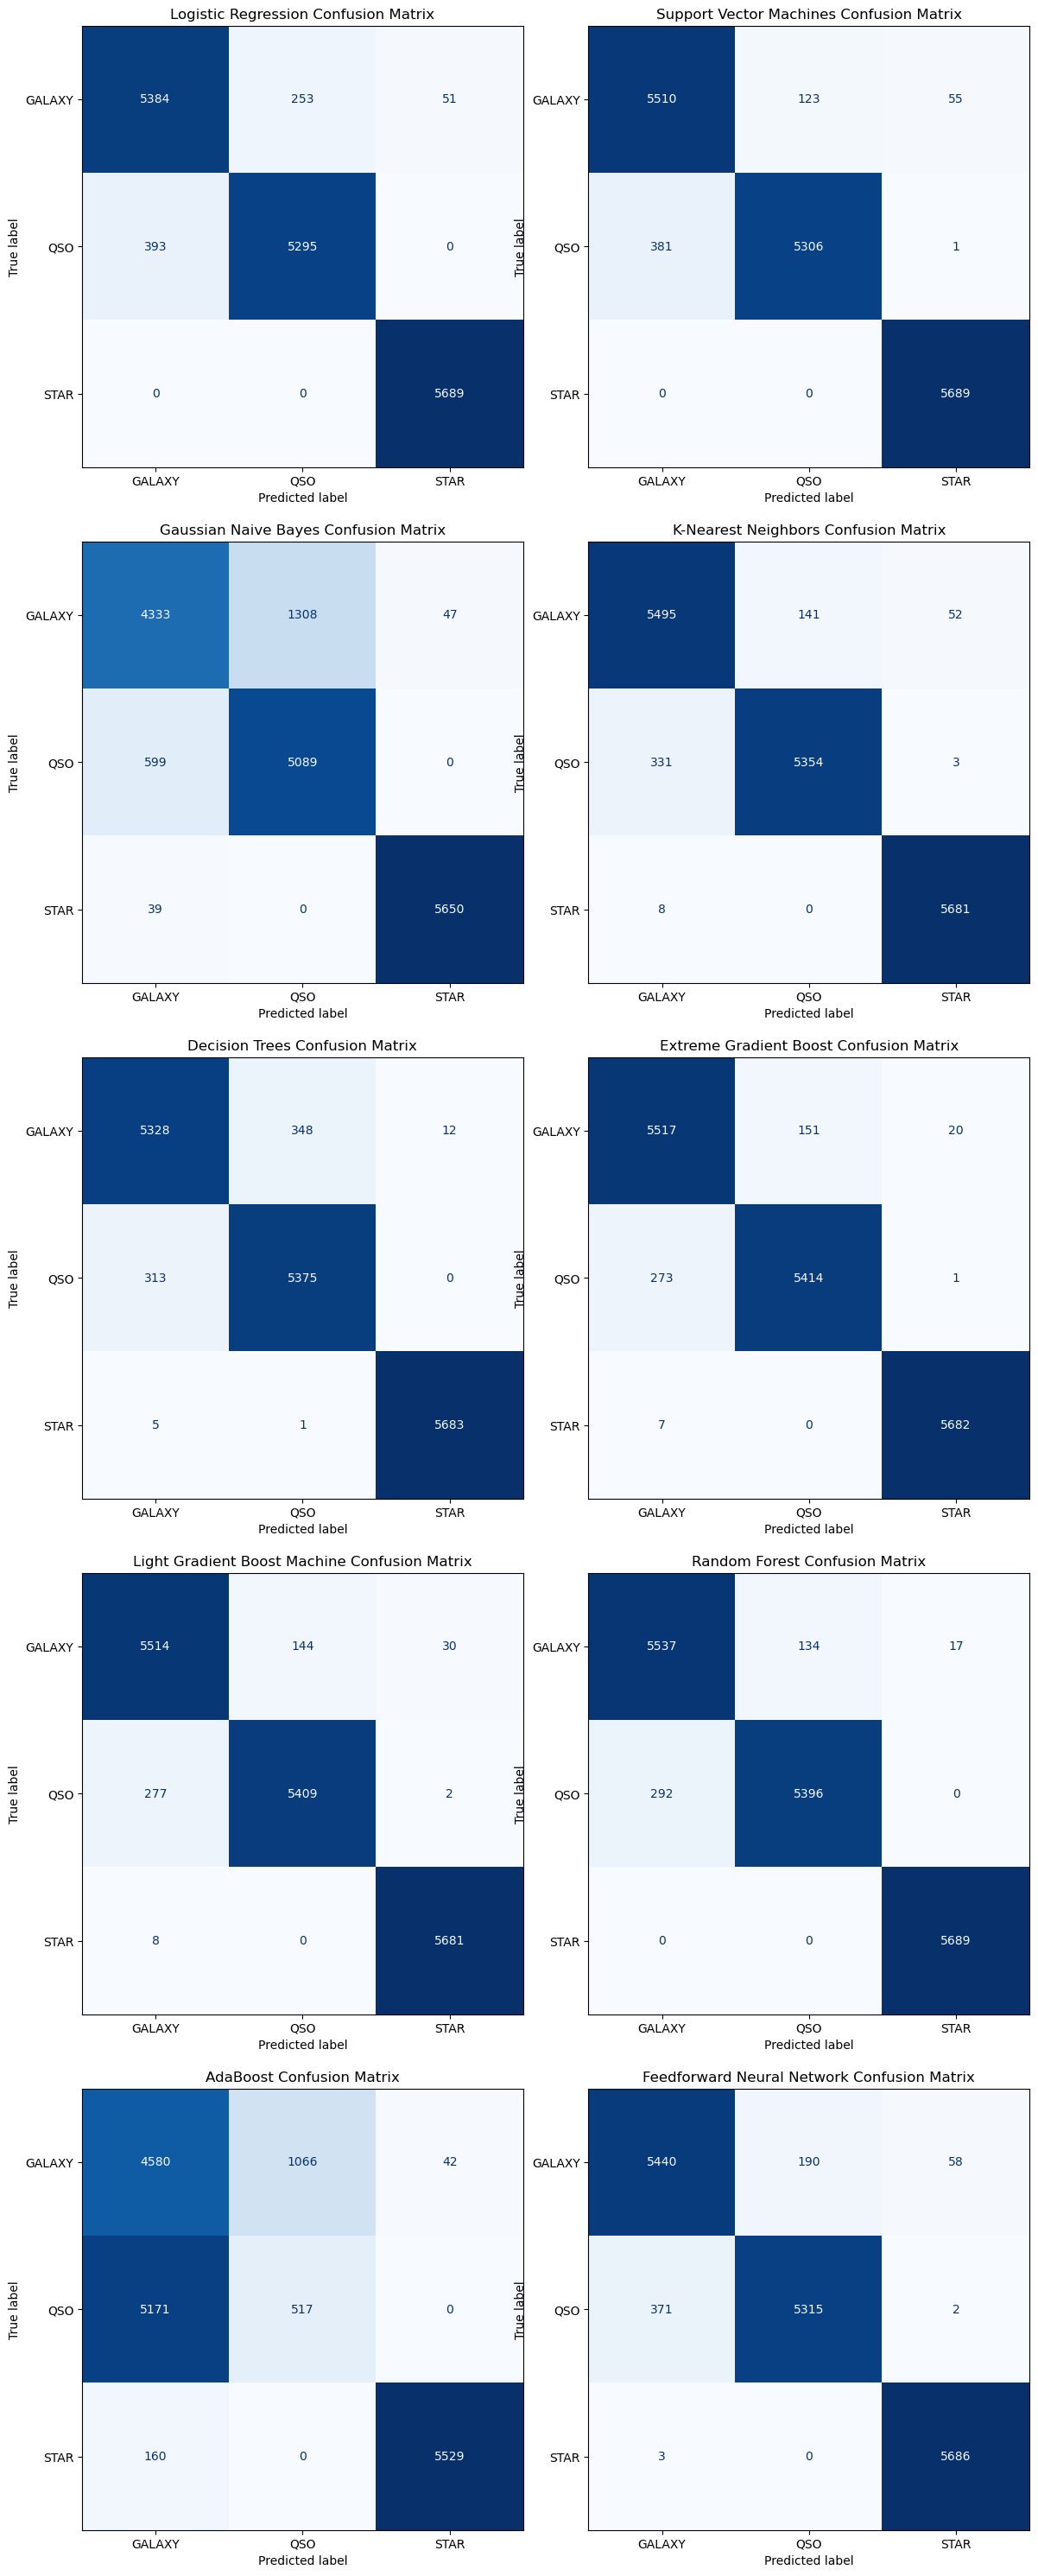

In [179]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

num_models = len(y_predictions_per_model)
num_cols = 2    
num_rows = (num_models + 1) // num_cols  # Calculate the number of rows needed

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, num_rows * 6))
axes = axes.flatten()

for idx, (predictions, model_name) in enumerate(zip(y_predictions_per_model, model_titles)):
    cm = confusion_matrix(y_test, predictions)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['GALAXY', 'QSO', 'STAR'])
    disp.plot(cmap='Blues', ax=axes[idx], colorbar=False)
    axes[idx].set_title(f"{model_name} Confusion Matrix")

for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

Here we can see the feature importance of all the models. This was scaled from 0 to 1 due to some models having too high values. 

It can also be seen that not all models have the *feature_importances_* attribute so only some models are shown.

With that it can be seen that **redshift** is a very detrimental feature when it comes to predicting the classes

Model_LogisticRegression() does not have feature_importances_ attribute and will be ignored.
Model_SVC(probability=True) does not have feature_importances_ attribute and will be ignored.
Model_GaussianNB() does not have feature_importances_ attribute and will be ignored.
Model_KNeighborsClassifier() does not have feature_importances_ attribute and will be ignored.
Model_<keras.engine.sequential.Sequential object at 0x00000170FFF88950> does not have feature_importances_ attribute and will be ignored.


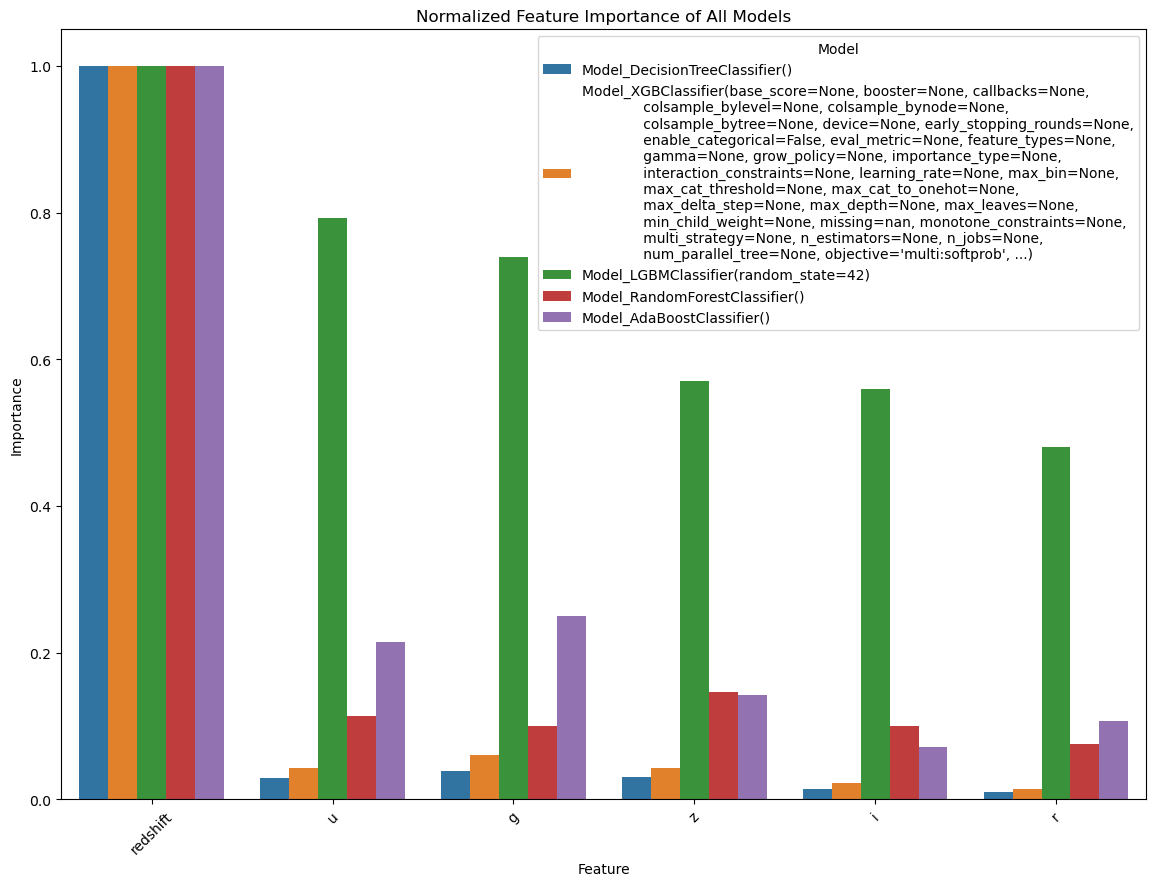

In [182]:
# Initialize an empty DataFrame to collect feature importances from all models
all_feature_importances = pd.DataFrame()

# Collect feature importances from each model
for i, model in enumerate(models_after_fitting_zero_shot):
    try:
        importances = model.feature_importances_
        # Normalize the importances to be between 0 and 1
        importances = importances / importances.max()
        
        feature_names = X_test.columns
        feature_importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances,
            'model': f'Model_{model}'
        })
        all_feature_importances = pd.concat([all_feature_importances, feature_importance_df])
    except AttributeError:
        print(f"Model_{model} does not have feature_importances_ attribute and will be ignored.")

# Check if we have collected any feature importances
if all_feature_importances.empty:
    print("None of the models have feature importances.")
else:
    # Sort the DataFrame to ensure consistent order of features
    all_feature_importances['feature'] = pd.Categorical(
        all_feature_importances['feature'], 
        categories=all_feature_importances.groupby('feature')['importance'].mean().sort_values(ascending=False).index,
        ordered=True
    )

    # Plot the grouped bar graph
    plt.figure(figsize=(14, 10))
    sns.barplot(data=all_feature_importances, x='feature', y='importance', hue='model')
    plt.title('Normalized Feature Importance of All Models')
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.legend(title='Model')
    plt.xticks(rotation=45)
    plt.show()


### Hyperparameter Tuning

We now get the top five models and tune each of them.

In [ ]:
top_models_zero_shot = [RandomForestClassifier(), XGBClassifier(), lgb.LGBMClassifier(), KNeighborsClassifier(), SVC()]
top_model_titles = [
    'Random Forest',
    'Extreme Gradient Boost',
    'Light Gradient Boost Machine',
    'K-Nearest Neighbors',
    'Support Vector Machines',
]

hyper_parameters = [
    {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0]
    },
    {
        'num_leaves': [31, 50, 100],
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [100, 200, 300]
    },
    {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto']
    }
]

models_after_hyperparameter_tuning = []

tuned_model_data = pd.DataFrame(columns=['Model', 'Accuracy', "Best Hyperparameters", "Time To Train"])

reports_after_tuning = []

In [ ]:
for title, model, param_grid in zip(top_model_titles, top_models_zero_shot, hyper_parameters):
    print(f"Training {title}")

    # Get start time
    start_time = time.time()

    # Start hyperparameter tuning
    report, best_model = train_with_tuning(model, param_grid, X_train, X_test, y_train, y_test)

    # Get end time
    end_time = time.time()

    # Get elapsed time
    elapsed_time = end_time - start_time
    print(f"Total time taken to train {title}: {elapsed_time:.2f} seconds")

    # Get best hyperparameters of the model
    hyperparameters = model.get_params()
    print(f"Best Hyperparameters: {hyperparameters}")

    # Append report data
    reports_after_tuning.append(report)
    print_classification_report(report)

    # Append Dataframe data
    tuned_model_data = pd.concat([tuned_model_data, pd.DataFrame({'Model': [title], 
                                                                  'Accuracy': [report['accuracy']], 
                                                                  "Best Hyperparameters": [hyperparameters], 
                                                                  "Time To Train": [elapsed_time]
                                                                  })], ignore_index=True)

    # Save models just in case
    models_after_hyperparameter_tuning.append(best_model)
    
    print("\n----------\n")

Training Random Forest
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Model Accuracy: 0.97
Classification Report:
{'0': {'precision': 0.9506003430531732, 'recall': 0.9743319268635724, 'f1-score': 0.9623198471956937, 'support': 5688}, '1': {'precision': 0.9761388286334056, 'recall': 0.9493670886075949, 'f1-score': 0.9625668449197861, 'support': 5688}, '2': {'precision': 0.9975451516745573, 'recall': 1.0, 'f1-score': 0.9987710674157303, 'support': 5689}, 'accuracy': 0.97456782888954, 'macro avg': {'precision': 0.9747614411203788, 'recall': 0.9745663384903892, 'f1-score': 0.9745525865104034, 'support': 17065}, 'weighted avg': {'precision': 0.9747627762338013, 'recall': 0.97456782888954, 'f1-score': 0.9745540057006117, 'support': 17065}}
Total time taken to train Random Forest: 697.62 seconds
Best Hyperparameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples':

In [ ]:
tuned_model_data

,Model,Accuracy,Best Hyperparameters,Time To Train
0,Random Forest,0.974568,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",697.622665
1,Extreme Gradient Boost,0.974509,"{'objective': 'binary:logistic', 'base_score':...",117.401529
2,Light Gradient Boost Machine,0.973044,"{'boosting_type': 'gbdt', 'class_weight': None...",60.905026
3,K-Nearest Neighbors,0.968473,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",3.198234
4,Support Vector Machines,0.968473,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",76.192002


In [ ]:
filenames = ["models/" + title.lower().replace(' ', '_') + "_tuned_model.joblib" for title in top_model_titles]
filenames

['models/random_forest_tuned_model.joblib',
 'models/extreme_gradient_boost_tuned_model.joblib',
 'models/light_gradient_boost_machine_tuned_model.joblib',
 'models/k-nearest_neighbors_tuned_model.joblib',
 'models/support_vector_machines_tuned_model.joblib']

In [ ]:
for filename, model in zip(filenames, models_after_hyperparameter_tuning):
    joblib.dump(model, filename)